<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW5_boosting_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Луговцев Тимур ДЗ5 ML


## **Домашняя работа 5: Бустинг и кластеризация**

### **Постановка задачи:**

В этой работы ваша задача подразделена на части:

*   В первой части вам предстоит реалищовать класс бустинга и сравнить его со встроенными классами популярных библиотек;
*   Во второй части вам предстоит применить алгоритмы кластеризации в задаче  разделения изображения на семантические компоненты;

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**

## **Часть 1: построение класса алгоритма бустинга**

**Количество баллов:** 7

Начнём с нужных библиотек и загрузки данных. Работать будем с датасетом из Kaggle и с синтетическим датасетом.

Данные c Kaggle связаны с телефонной рекламой португальского банковского учреждения. Цель классификации — спрогнозировать, подпишется ли клиент на срочный депозит (переменная y).

Всего в данных 20 признаков, ознакомиться с признаковым описанием можно [здесь](https://www.kaggle.com/code/sachinrajput17/subscription-prediction-for-bank-marketing-data).

Будем действовать из предположений, что датасет достаточно хорош, чтобы мы уже могли построить на нём базовую модель.

In [2]:
%pip install plotly

     ---------------------------------------- 14.8/14.8 MB 6.5 MB/s eta 0:00:00
     -------------------------------------- 306.6/306.6 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

In [4]:
# !wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [5]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

age            job  marital          education  default housing loan  \
1063   27         admin.  married  university.degree       no     yes   no   
8713   29         admin.  married           basic.9y       no     yes   no   
6245   27         admin.   single  university.degree       no     yes  yes   
4622   29  self-employed  married  university.degree  unknown     yes   no   
183    57     technician  married           basic.4y  unknown      no   no   

        contact month day_of_week  ...  campaign  pdays  previous  \
1063   cellular   sep         tue  ...         2      6         2   
8713  telephone   nov         fri  ...         1    999         0   
6245   cellular   jun         mon  ...         1    999         0   
4622  telephone   jun         wed  ...         6    999         0   
183   telephone   jun         thu  ...         2    999         0   

         poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
1063      failure         -3.4          92.379          -29.8      0.770   
8713  nonexistent         -0.1          93.200          -42.0      4.474   
6245  nonexistent         -2.9          92.963          -40.8      1.266   
4622  nonexistent          1.4          94.465          -41.8      4.959   
183   nonexistent          1.4          94.465          -41.8      4.958   

      nr.employed  y  
1063       5017.5  1  
8713       5195.8  1  
6245       5076.2  1  
4622       5228.1 -1  
183        5228.1 -1  

[5 rows x 21 columns]

Разделим на train и test (random_state не меняем)

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Генерируем синтетические данные (seed не меняем)

In [7]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [8]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''

    mask = np.random.choice([True, False], size=features.shape[0],
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps

    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)

    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')

    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()

    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

### **Задание 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации**

Реализовывать класс буситнга необходимо согласно его теоретическому описанию. Вы начинаете с параметрами:

- `base_model_class=DecisionTreeRegressor` — базовая модель
- `base_model_params: dict={'max_features': 0.1}` — параметрмы базовой модели, рассчет максимального количества признаков полагаем как: `max(1, int(max_features * n_features_in_))`
- `n_estimators: int=10` — количество моделей
- `learning_rate: float=0.1` — скорость обучения
- `subsample: float=0.3` — доля данных, которая будет использоваться для подбора отдельных алгоритмов.
— `random_seed: int=228` — тут как всегда
– `custom_loss: list or tuple=None` — функция потерь
— `use_best_model: bool=False` — использовать ли при вызове predict и predict_proba лучшее с точки зрения валидационной выборки число деревьев в композиции
— `n_iter_early_stopping: int=None` — ранний критерий остановки

**Примечание:**

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже).

**Примечание 2:**

Нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [31]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class Boosting:

    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict = {'max_features': 0.1},
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        subsample: float = 0.3,
        random_seed: int = 228,
        custom_loss: list or tuple = None,
        use_best_model: bool = False,
        n_iter_early_stopping: int = None
    ):
        self.base_model_class = base_model_class
        self.base_model_params = base_model_params
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.random_seed = random_seed
        self.custom_loss = custom_loss
        self.use_best_model = use_best_model
        self.n_iter_early_stopping = n_iter_early_stopping

        self.initial_model_pred = None
        self.gammas = []
        self.models = []
        self.n_features_in_ = None

        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        model = self.models[n_model]
        model.fit(X, y)

    def _fit_initial_model(self, X, y):
        y = np.asarray(y)
        p = (y == 1).mean()
        eps = 1e-10
        self.initial_model_pred = np.log((p + eps) / (1 - p + eps))

    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list = (0.01, 1)):
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        gammas = np.linspace(*boundaries, 100)
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss
        return optimal_gamma

    def fit(self, X, y, eval_set=None):
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_features_in_ = X.shape[1]
        max_features_param = self.base_model_params.get('max_features', 1.0)
        computed_max_features = max(1, int(max_features_param * self.n_features_in_))
        updated_params = {**self.base_model_params, 'max_features': computed_max_features}
        self.models = [self.base_model_class(**updated_params) for _ in range(self.n_estimators)]

        self._fit_initial_model(X, y)
        current_predictions = np.full(X.shape[0], self.initial_model_pred, dtype=np.float64)

        best_loss = np.inf
        best_iteration = 0
        no_improvement_count = 0
        if eval_set is not None:
            X_val, y_val = eval_set
            val_predictions = np.full(y_val.shape, self.initial_model_pred, dtype=np.float64)
        else:
            val_predictions = None

        for n_model in range(self.n_estimators):
            if (self.n_iter_early_stopping is not None and
                    no_improvement_count >= self.n_iter_early_stopping):
                break

            n_samples = X.shape[0]
            subsample_size = int(self.subsample * n_samples)
            if subsample_size < 1:
                subsample_size = 1
            rng = np.random.RandomState(self.random_seed + n_model)
            subsample_indices = rng.choice(n_samples, subsample_size, replace=False)
            X_subsample = X[subsample_indices]
            y_subsample_current = current_predictions[subsample_indices]

            gradients = -self.loss_derivative(y[subsample_indices], y_subsample_current)
            self._fit_new_model(X_subsample, gradients, n_model)
            new_predictions = self.models[n_model].predict(X)

            optimal_gamma = self._find_optimal_gamma(y, current_predictions, new_predictions)
            gamma = optimal_gamma * self.learning_rate
            current_predictions += gamma * new_predictions
            self.gammas.append(gamma)

            if eval_set is not None:
                val_new_predictions = self.models[n_model].predict(X_val)
                val_predictions += gamma * val_new_predictions
                val_loss = self.loss_fn(y_val, val_predictions)
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_iteration = n_model + 1
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1
                if (self.n_iter_early_stopping is not None and
                        no_improvement_count >= self.n_iter_early_stopping):
                    self.models = self.models[:best_iteration]
                    self.gammas = self.gammas[:best_iteration]
                    break

        if self.use_best_model and eval_set is not None:
            self.best_iteration_ = best_iteration
        return self

    def predict(self, X: np.ndarray):
        proba = self.predict_proba(X)[:, 1]
        return np.where(proba >= 0.5, 1, -1)

    def predict_proba(self, X: np.ndarray):
        if self.use_best_model and hasattr(self, 'best_iteration_'):
            n_models = self.best_iteration_
        else:
            n_models = len(self.models)
        predictions = np.full(X.shape[0], self.initial_model_pred, dtype=np.float64)
        for i in range(n_models):
            predictions += self.gammas[i] * self.models[i].predict(X)
        proba = self.sigmoid(predictions)
        return np.vstack([1 - proba, proba]).T
    
    def get_params(self, deep=True):
        """
        Возвращает параметры модели в виде словаря.
        """
        return {
            "base_model_class": self.base_model_class,
            "base_model_params": self.base_model_params,
            "n_estimators": self.n_estimators,
            "learning_rate": self.learning_rate,
            "subsample": self.subsample,
            "random_seed": self.random_seed,
            "custom_loss": self.custom_loss,
            "use_best_model": self.use_best_model,
            "n_iter_early_stopping": self.n_iter_early_stopping,
        }
    def set_params(self, **params):
        """
        Устанавливает параметры модели.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

    @property
    def feature_importances_(self):
        if not hasattr(self, 'n_features_in_'):
            raise ValueError("Model not fitted yet.")
        importances = np.zeros(self.n_features_in_)
        if self.use_best_model and hasattr(self, 'best_iteration_'):
            models = self.models[:self.best_iteration_]
            gammas = self.gammas[:self.best_iteration_]
        else:
            models = self.models
            gammas = self.gammas
        for gamma, model in zip(gammas, models):
            if hasattr(model, 'feature_importances_'):
                importances += gamma * model.feature_importances_
        if importances.sum() != 0:
            importances /= importances.sum()
        return importances

## **Тест для вашей имплементации.**

Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [10]:
# %%time

boosting = Boosting()
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности

preds = np.argmax(boosting.predict_proba(X_test_synthetic), 1)
print(accuracy_score((y_test_synthetic == 1), preds))

0.90955


In [11]:
%%time

boosting = Boosting()
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.argmax(boosting.predict_proba(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values), 1)

print(accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87)

True
CPU times: total: 172 ms
Wall time: 540 ms


In [12]:
print(accuracy_score((df_test.y.values == 1), np.round(preds)))

0.8798491379310345


### **Задание 2. (1.2 балла) Сравнение с базовыми моделями**

- Сравните результаты вашей имплементации бустинга с указанными ниже базовыми моделями на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных. Данные берите из реальной задачи.
- Ответьте на поставленные вопросы

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

In [14]:
# Some EDA 
data = pd.read_csv('bank_data.csv')
print(data.isnull().sum())
categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

X = data.drop('y', axis=1)  
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Random Forest
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest_test = forest.predict(X_test)
y_pred_forest_train = forest.predict(X_train)
f1_forest_test = f1_score(y_test, y_pred_forest_test)
accuracy_forest_test = accuracy_score(y_test, y_pred_forest_test)
f1_forest_train = f1_score(y_train, y_pred_forest_train)
accuracy_forest_train = accuracy_score(y_train, y_pred_forest_train)
print(f"Random Forest - Train Accuracy: {accuracy_forest_train}, Train F1: {f1_forest_train}")
print(f"Random Forest - Test Accuracy: {accuracy_forest_test}, Test F1: {f1_forest_test}")

Random Forest - Train Accuracy: 1.0, Train F1: 1.0
Random Forest - Test Accuracy: 0.8814655172413793, Test F1: 0.8831030818278427


In [22]:
# logreg
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg_test = log_reg.predict(X_test)
y_pred_log_reg_train = log_reg.predict(X_train)
f1_log_reg_test = f1_score(y_test, y_pred_log_reg_test)
accuracy_log_reg_test = accuracy_score(y_test, y_pred_log_reg_test)
f1_log_reg_train = f1_score(y_train, y_pred_log_reg_train)
accuracy_log_reg_train = accuracy_score(y_train, y_pred_log_reg_train)
print(f"Logistic Regression - Train Accuracy: {accuracy_log_reg_train}, Train F1: {f1_log_reg_train}")
print(f"Logistic Regression - Test Accuracy: {accuracy_log_reg_test}, Test F1: {f1_log_reg_test}")

Logistic Regression - Train Accuracy: 0.8755387931034483, Train F1: 0.8782608695652174
Logistic Regression - Test Accuracy: 0.8679956896551724, Test F1: 0.8676391139924365


c:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [20]:
tree = DecisionTreeClassifier(max_depth=6, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
f1_tree_test = f1_score(y_test, y_pred_tree)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
y_pred_tree_train = tree.predict(X_train)
f1_tree_train = f1_score(y_train, y_pred_tree_train)
accuracy_tree_train = accuracy_score(y_train, y_pred_tree_train)

print(f"Decision Tree - Train Accuracy: {accuracy_tree_train}, Train F1: {f1_tree_train}")
print(f"Decision Tree - Test F1: {f1_tree_test}, Test F1: {f1_tree_test}")

Decision Tree - Train Accuracy: 0.8918372844827587, Train F1: 0.8951560255908082
Decision Tree - Test F1: 0.8812095032397408, Test F1: 0.8812095032397408


In [25]:
boosting_model = Boosting()  
boosting_model.fit(X_train, y_train)
y_pred_boosting_test = boosting_model.predict(X_test)
y_pred_boosting_train = boosting_model.predict(X_train)
f1_boosting_test = f1_score(y_test, y_pred_boosting_test)
accuracy_boosting_test = accuracy_score(y_test, y_pred_boosting_test)
f1_boosting_train = f1_score(y_train, y_pred_boosting_train)
accuracy_boosting_train = accuracy_score(y_train, y_pred_boosting_train)

print(f"Boosting - Train Accuracy: {accuracy_boosting_train}, Train F1: {f1_boosting_train}")
print(f"Boosting - Test Accuracy: {accuracy_boosting_test}, Test F1: {f1_boosting_test}")

Boosting - Train Accuracy: 0.9500269396551724, Train F1: 0.951560255908082
Boosting - Test Accuracy: 0.8626077586206896, Test F1: 0.8619382782891175


c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\skl

**Вопросы:**

1) Какая из моделей имеет оптимальное качество? С чем это связано?

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?


**Ваш ответ здесь**

1 - Random Forest. Имеет самые высокие метрики (добавил f1 score чтобы учесть точность и полноту) так как это в целом ансамблевый метод который (по дефолту без тюнинга параметров) работает лучше чем 1 дерево (доказано на лекциях), улавливает нелинейные зависимости(лучше логрега) и не надо тюнить как ванильный бустинг который мы реализовали.

2 - Оба ансамблевых метода (бустинг и лес) переобучаются +- одинаково. Использования ранней остановки и обрезания у бустпнга не имеют смысла тк деревья там предполагаются и так короткими. Скорее поможет уменьшение кол-ва weak learners.

3 - Если строить линейные регрессии по остаткам каждой из предыдущих это нарушит условия теоремы Гаусса-Маркова и такая модель будет работать хуже(или так же) как 1 логрег в среднем. Плюс бустинг как техника создавался чтобы уменьшить bias weak learner-ов а у линрега он и так маленький



### **Задание 3. (0.8 балла) Сравнение с бустингами**

- Сравните на реальных данных данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией.
- Укажите, получилось ли у вас победить библиотечные реализации на тестовых данных?

**Примечание:**

Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов.


In [32]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
param_grid_custom = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.3, 0.5, 0.7],  
}


custom_boosting = Boosting()
grid_search_custom = GridSearchCV(
    estimator=custom_boosting,
    param_grid=param_grid_custom,
    scoring=make_scorer(f1_score),  
    cv=3,  
    n_jobs=-1, 
    verbose=2  
)

grid_search_custom.fit(X_train, y_train)
y_pred_custom_test = grid_search_custom.predict(X_test)
f1_custom_test = f1_score(y_test, y_pred_custom_test)
accuracy_custom_test = accuracy_score(y_test, y_pred_custom_test)
print(f"Custom Boosting - Test Accuracy: {accuracy_custom_test}, Test F1: {f1_custom_test}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Custom Boosting - Test Accuracy: 0.8782327586206896, Test F1: 0.879144385026738


c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

c:\Users\User\miniconda3\lib\site-packages\skl

In [33]:
# %pip install catboost
from catboost import CatBoostClassifier
param_grid_catboost = {
    'n_estimators': [10, 50, 100], 
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.3, 0.5, 0.7]
   
}

catboost = CatBoostClassifier(random_seed=228, verbose=0)

grid_search_catboost = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid_catboost,
    scoring=make_scorer(f1_score), 
    cv=3,  
    n_jobs=-1, 
    verbose=2 
)
grid_search_catboost.fit(X_train, y_train)
y_pred_catboost_test = grid_search_catboost.predict(X_test)
f1_catboost_test = f1_score(y_test, y_pred_catboost_test)
accuracy_catboost_test = accuracy_score(y_test, y_pred_catboost_test)
print(f"CatBoost - Test Accuracy: {accuracy_catboost_test}, Test F1: {f1_catboost_test}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
CatBoost - Test Accuracy: 0.8981681034482759, Test F1: 0.898876404494382


**Ваш ответ здесь**
Не получилось)
Но Catboost сам по себе имеет свойство быть лучше чем ванильный бустинг(в статье описаны основные отличия и модификации, не буду их перечислять), поэтому даже с подбором параметров результат был ожидаем.

###**Задание 4. (1 балл) Капля теории**

Теоретически, мы могли бы построить бэггинг на логистических регрессиях. Оцените целесообразность такого подхода. В ответе укажите:

- Идею бэггинга и его свойства;
- Характеристики модели логистической регресии;
- Сопоставление и вывод.




Бэггинг (Bootstrap Aggregating) — это ансамблевый метод, основанный на создании множества моделей, обученных на различных подвыборках исходных данных, с последующим усреднением их предсказаний. Его ключевая цель — снижение дисперсии ошибки за счет агрегации результатов независимых моделей, что особенно эффективно для алгоритмов с высокой вариативностью, таких как глубокие деревья решений. Однако логистическая регрессия, будучи линейной моделью, обладает принципиально иными свойствами: она имеет низкую дисперсию и высокое смещение в случае нелинейных зависимостей в данных. Это делает её плохим кандидатом для бэггинга, так как метод не способен компенсировать систематическое смещение, а лишь снижает случайную вариативность, которой у логистической регрессии и так мало. Кроме того, все копии модели в ансамбле будут строить схожие линейные границы решения, что лишает бэггинг главного преимущества — разнообразия предсказаний. Усреднение коэффициентов множества линейных моделей эквивалентно обучению одной регрессии на полном наборе данных, что сводит на нет смысл ансамбля. При этом вычислительные затраты на обучение и агрегацию десятков или сотен идентичных по природе моделей становятся неоправданными. Таким образом, бэггинг на логистических регрессиях не только не улучшает качество предсказаний, но и не решает ключевые проблемы, присущие линейным методам, — неспособность улавливать сложные нелинейные взаимосвязи. Для задач, где логистическая регрессия показывает недостаточную точность, более целесообразно использовать ансамбли с нелинейными базовыми моделями (например, градиентный бустинг или случайный лес) или переходить к алгоритмам, способным аппроксимировать нелинейности, таким как нейронные сети.

## **Часть 1: Разделение изображения на семантические компоненты**

**Количество баллов:** 3

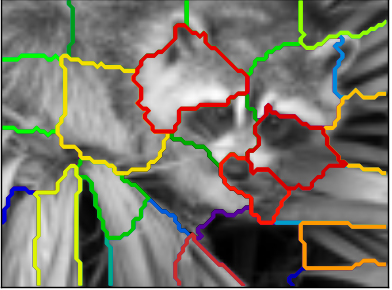

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации.

Проверим их на ```duck.jpg``` и ```owls.jpg```

### **Задание 5 (0.2 балла)**

Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [34]:
from PIL import Image
# or
#import cv2

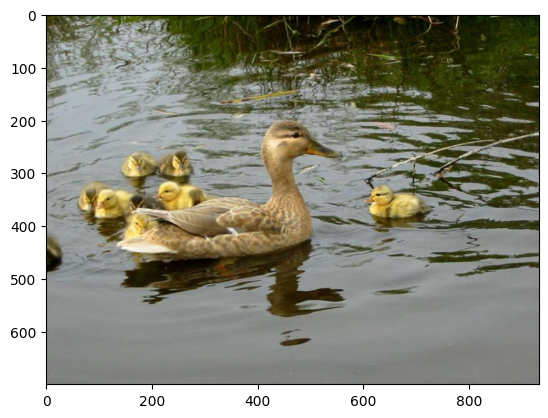

In [37]:
image = Image.open("duck.jpg")
plt.imshow(image)

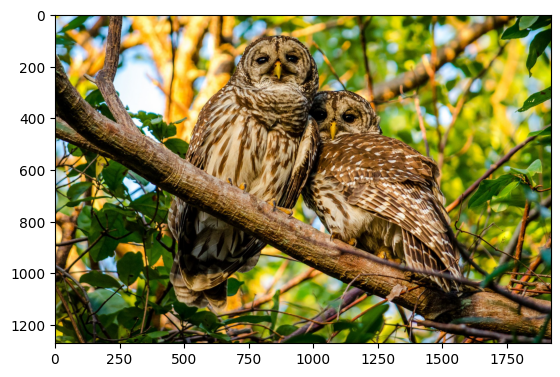

In [38]:
image = Image.open("owls.jpg")
plt.imshow(image)

### **Задание 6 (0.8 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

- Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :))
- Проанализируйте результат

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image


def find_components(image_path, lambda_value, n_clusters=3):

    image = Image.open(image_path)
    image = np.array(image)
    height, width, _ = image.shape
    features = []
    for y in range(height):
        for x in range(width):
            r, g, b = image[y, x, :3]
            features.append([lambda_value * x, lambda_value * y, r, g, b])
    features = np.array(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)

    clustered_image = np.zeros_like(image)
    for y in range(height):
        for x in range(width):
            idx = y * width + x
            clustered_image[y, x] = kmeans.cluster_centers_[labels[idx], 2:].astype(int)

    return clustered_image

def plot_images(original, clustered, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(clustered)
    plt.title(title)
    plt.axis('off')

    plt.show()

image_path = "duck.jpg"
image = np.array(Image.open(image_path))
clustered_03 = find_components(image_path, lambda_value=0.3, n_clusters=3)
clustered_15 = find_components(image_path, lambda_value=1.5, n_clusters=3)
image_path = "owls.jpg"
image_owls = np.array(Image.open(image_path))
clustered_03_owls = find_components(image_path, lambda_value=0.3, n_clusters=3)
clustered_15_owls = find_components(image_path, lambda_value=1.5, n_clusters=3)


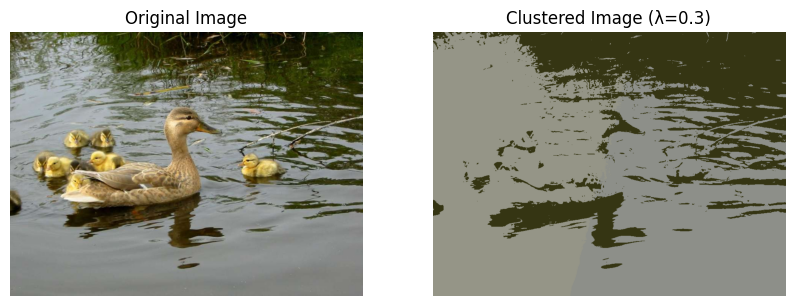

In [42]:
plot_images(image, clustered_03, "Clustered Image (λ=0.3)")

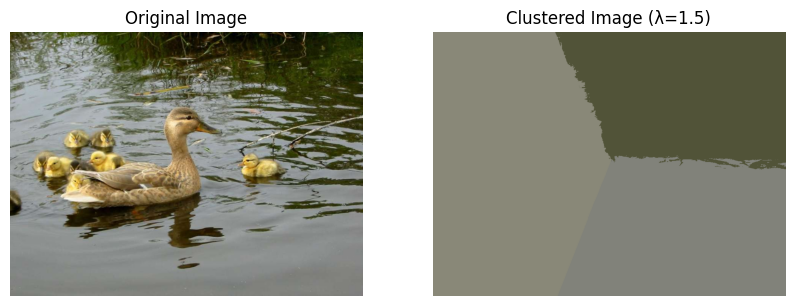

In [43]:
plot_images(image, clustered_15, "Clustered Image (λ=1.5)")

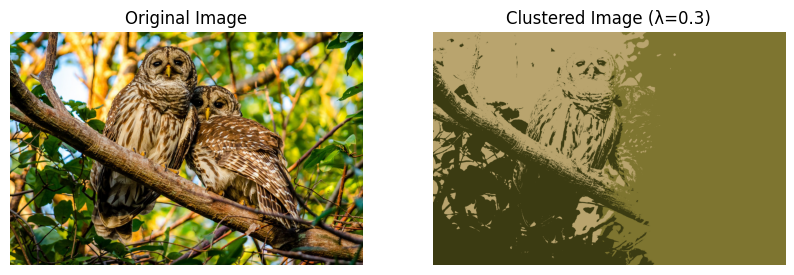

In [44]:
plot_images(image_owls, clustered_03_owls, "Clustered Image (λ=0.3)")

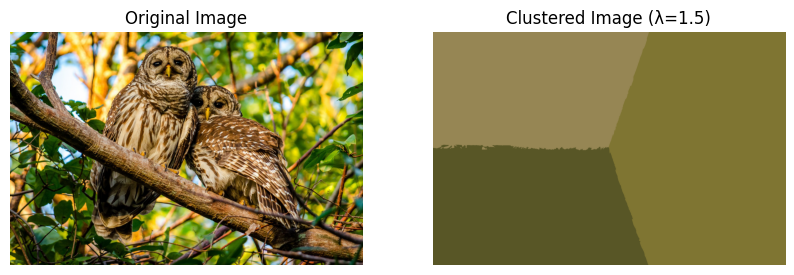

In [45]:
plot_images(image_owls, clustered_15_owls, "Clustered Image (λ=1.5)")

**Ваш ответ здесь**

Параметра lambda контролирует преобладающие (средние по rgb) цвета на каждом сегменте картинке. 
При малом значении λ λ пространственные координаты ( x i ,y i ​ ) имеют меньший вес по сравнению с цветовыми компонентами ( r i , g i , b i ​ ).
Соответсвенно, 
При его увеличении цвета картинки стираются и становятся важны регионы 'одной цветовой гаммы' то есть контуры становятся более различимыми а само цветовое наполнение картинки менее различимым

### **Задание 7 (0.8 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

### **Задание 8 (0.2 балла)**
- Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.
- Проанализируйте сравнение

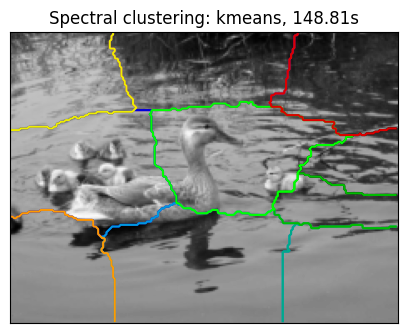

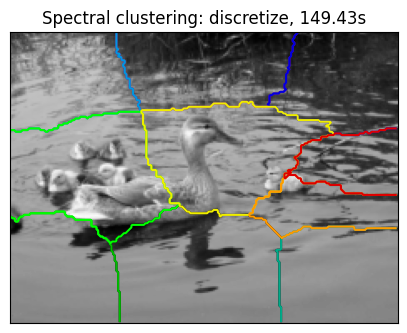

In [65]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from skimage import io, color, transform


image_path = "duck.jpg"
img = color.rgb2gray(io.imread(image_path))
img = transform.rescale(img, 0.25) 
graph = image.img_to_graph(img)

beta = 5
graph.data = np.exp(-beta * graph.data / img.std()) + 1e-6


N_REGIONS = 10  
for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=1)
    t1 = time.time()
    labels = labels.reshape(img.shape)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    for l in range(N_REGIONS):
        plt.contour(labels == l, colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    plt.title(f'Spectral clustering: {assign_labels}, {t1 - t0:.2f}s')
    plt.show()

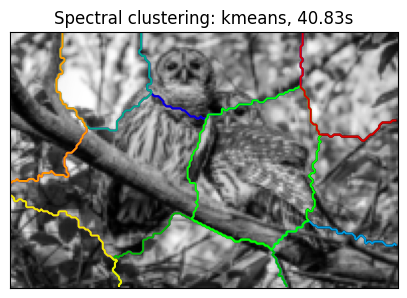

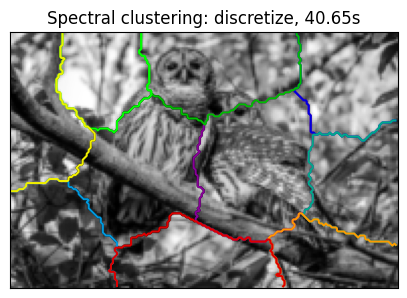

In [67]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from skimage import io, color, transform


image_path = "owls.jpg"
img = color.rgb2gray(io.imread(image_path))
img = transform.rescale(img, 0.1) 
graph = image.img_to_graph(img)

beta = 5
graph.data = np.exp(-beta * graph.data / img.std()) + 1e-6


N_REGIONS = 10  
for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=1)
    t1 = time.time()
    labels = labels.reshape(img.shape)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    for l in range(N_REGIONS):
        plt.contour(labels == l, colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    plt.title(f'Spectral clustering: {assign_labels}, {t1 - t0:.2f}s')
    plt.show()

**Ваш ответ здесь**

Тк я использовал не так много регионов то и результат получился сомнительный. Оба метода отделают голову мамы-утки, ее отражение на воде,  а также ее утят в различные регионы, то же самое можно сказать про 2 региона с листвой наверху картинки. Однако осмысленных выводов не сделать. Кроме того, из-за того что волны в чб фильтре выглядят вполне как контуры - границы бОльшей части регионов проходят как разь по ним, поэтому стоит как-то их потенциально сгладить перед кластеризацией(?)

Аналогично с картинкой с совой. 
Контуры выделаются чуть лучше, но из-за листьев на фоне большинство кластеров продолжают быть неинформативными. Четко выделяются кластеры с лицом левой совы, ее телом и телом право совы. Также проблеск света в левом верхнем углу из-за своей контркстности попал в отдельный кластер. Вывол - также сложная для сегментации (из-за листьев на заднем плане) картинка.

### **Задание 9 (1 балл)**

- Найдите интересную картинку милого животного и примените алгоритмы и к ней. Поэкспериментируйте с параметрами алгоритмов и постарайтесь добиться оптимального результата. Картинку нужно будет загрузить вместе с работой.

- Сравните два подхода и сегментации, к которым они приводят. Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

**Примечание:**

Слишком большие лучше не брать - считаться будет долго. Не забудьте визуализировать!


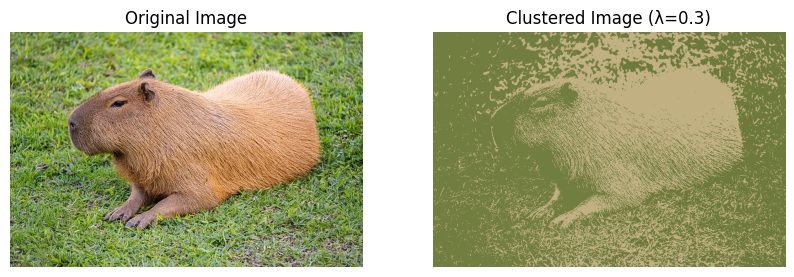

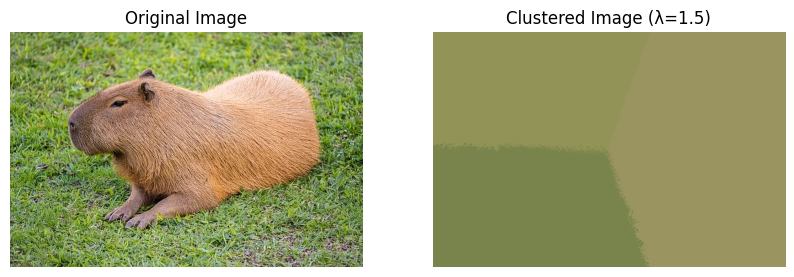

In [68]:
image_path = "capybara.jpg"
image = np.array(Image.open(image_path))
clustered_03 = find_components(image_path, lambda_value=0.3, n_clusters=3)
clustered_15 = find_components(image_path, lambda_value=1.5, n_clusters=3)
plot_images(image, clustered_03, "Clustered Image (λ=0.3)")
plot_images(image, clustered_15, "Clustered Image (λ=1.5)")

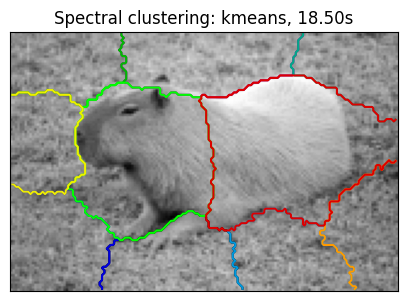

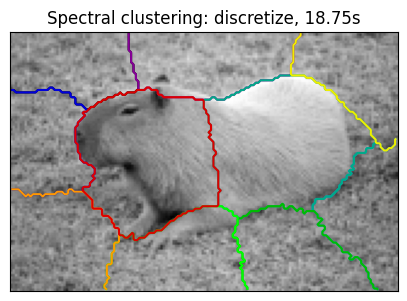

In [69]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from skimage import io, color, transform


image_path = "capybara.jpg"
img = color.rgb2gray(io.imread(image_path))
img = transform.rescale(img, 0.25) 
graph = image.img_to_graph(img)

beta = 5
graph.data = np.exp(-beta * graph.data / img.std()) + 1e-6


N_REGIONS = 10  
for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=1)
    t1 = time.time()
    labels = labels.reshape(img.shape)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    for l in range(N_REGIONS):
        plt.contour(labels == l, colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    plt.title(f'Spectral clustering: {assign_labels}, {t1 - t0:.2f}s')
    plt.show()

**Ваш ответ здесь**

В случае с капибарой и довольно простой картинкой результаты получше. 
Если для первого k-means не сильно отличается качество контуров от того что видели на картинках с утками и совами ( по причинам описанным выше) + слишком большую lambda также лучше не брать, 

то спектральный анализ четко выделил голову капибары и ее туловище. Таким образом общий контур животного намного четче и ясно отделим от заднего фона (травы)
Короче проще картинка - лучше качество...

## **Бонус (1 балл)**

В качестве бонуса предлагаем вам построить алгоритм кластеризации типов движения на наборе Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

### **Задание 1 (0.05 балла)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 2 (0.05 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 3 (0.15 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мспользуем методы **понижения размерности**. В частности, мы будем использовать метод главных компонент. Если вы проходили степик, то знакомы с ним, если нет, то почитать про PCA вам нужно в [Конспекте](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture12-factorizations.pdf).

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма массива pca.explained_variance_ratio_ должна быть больше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 4. (0.15 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 6 (0.05 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 7 (0.1 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш ответ здесь.**

### **Задание 8 (0.15 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш ответ здесь.**

### **Задание 9 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш ответ здесь.**

**Вы ещё здесь!** или **уже**?)

Спасибо за труд! Котобонус:

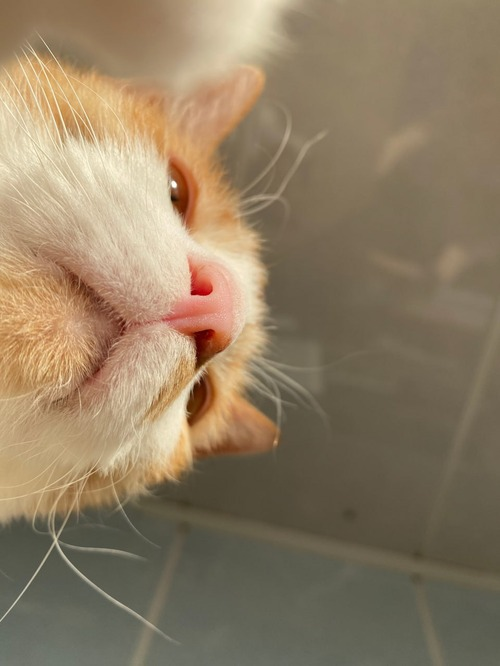